In [1]:
import pandas as pd 
import numpy as np 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../traces/final_data.csv")

In [ ]:
df.head()

,arrival_timestamp,regions,model_type,workload_type,prompt_size,token_size,client_tenant,request_id,batch_id,scenario,sla,utility,request_type,application_id,batch_size
0,0.00000,120,C,dev,702,64,8,5399999,-1,ES,10,1,2,-1,1
1,0.00000,210,B,prod,862,14,4,10399999,-1,ES,10,1,2,-1,1
2,0.00000,120,A,prod,4690,99,4,1499999,-1,ES,10,1,2,-1,1
3,0.00000,210,D,prod,929,77,4,6899999,-1,ES,10,1,2,-1,1
4,0.13163,21,D,prod,7091,81,4,6899998,-1,ES,10,1,2,-1,1


In [ ]:
df["arrival_timestamp"].max()

604798.888597

In [ ]:
df["application_id"].value_counts()

application_id
-1    7200000
Name: count, dtype: int64

In [6]:
df.columns

Index(['arrival_timestamp', 'regions', 'model_type', 'workload_type',
       'prompt_size', 'token_size', 'client_tenant', 'request_id', 'batch_id',
       'scenario', 'sla', 'utility', 'request_type', 'application_id',
       'batch_size'],
      dtype='object')

In [7]:
df["arrival_timestamp_int"] = df["arrival_timestamp"].apply(int)

In [8]:
df = df[["request_id", "sla", "utility", "model_type", "workload_type", "arrival_timestamp", "arrival_timestamp_int", "prompt_size", "token_size", "regions"]]

In [9]:
df.head()

,request_id,sla,utility,model_type,workload_type,arrival_timestamp,arrival_timestamp_int,prompt_size,token_size,regions
0,5399999,10,1,C,dev,0.00000,0,702,64,120
1,10399999,10,1,B,prod,0.00000,0,862,14,210
2,1499999,10,1,A,prod,0.00000,0,4690,99,120
3,6899999,10,1,D,prod,0.00000,0,929,77,210
4,6899998,10,1,D,prod,0.13163,0,7091,81,21


In [10]:
df.loc[df["model_type"] == "B"][["prompt_size", "token_size"]].quantile([.99])

,prompt_size,token_size
0.99,49424.01,2000.0


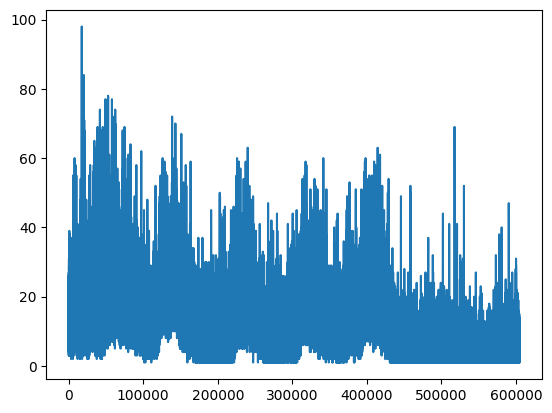

In [11]:
df_plotter = df.groupby("arrival_timestamp_int").agg({"request_id": "count"}).reset_index()
plt.plot(df_plotter["arrival_timestamp_int"], df_plotter["request_id"])
plt.show()

In [12]:
# import matplotlib
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     "font.serif": "Times New Roman",
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })
# # plt.rcParams["font.family"] = "serif"
# # plt.rcParams["font.serif"] = ["Times New Roman"]



In [13]:
one_day = 24*60*60

/tmp/ipykernel_112753/1296403791.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["arrival_timestamp_int"] = df_temp["arrival_timestamp_int"].apply(lambda x: 60 * (x//60))
/tmp/ipykernel_112753/1296403791.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["arrival_timestamp_int"] = df_temp["arrival_timestamp_int"].apply(lambda x: 60 * (x//60))
/tmp/ipykernel_112753/1296403791.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

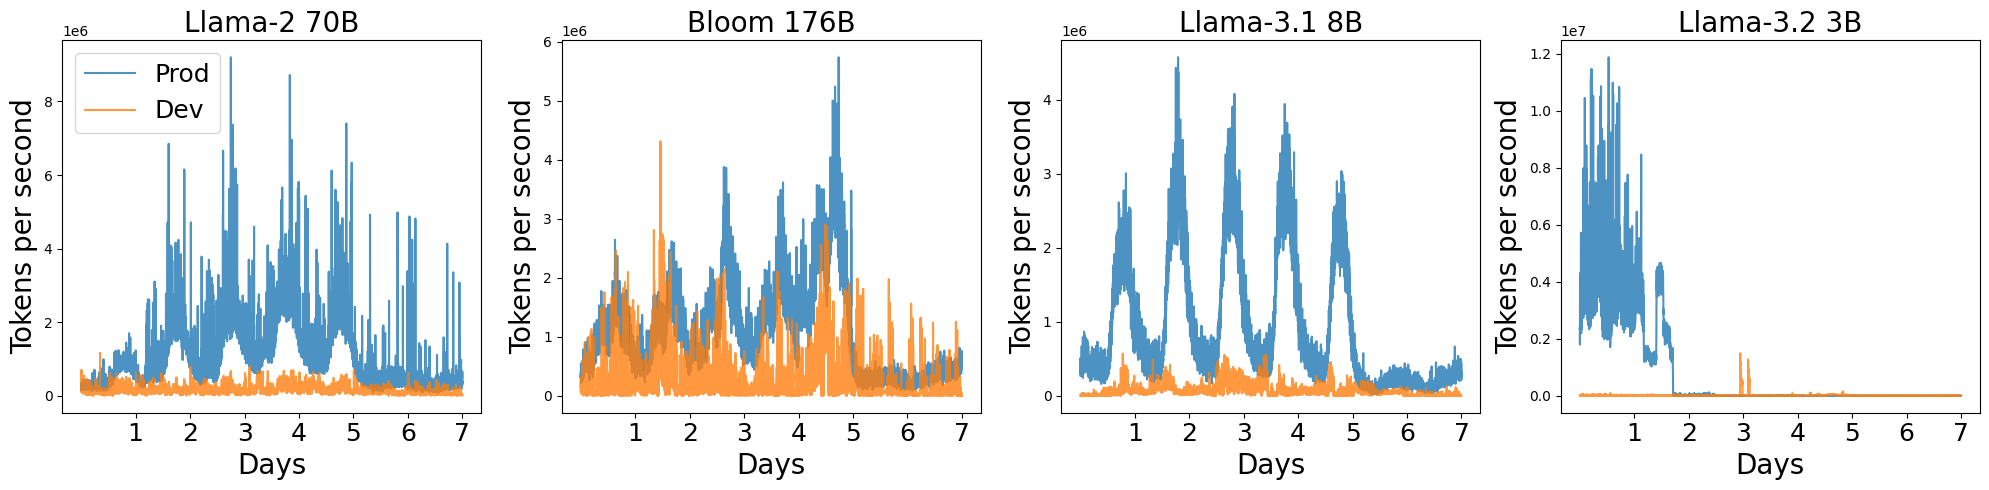

In [16]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

pl = ax[0]
df_A = df.loc[df["model_type"] == "A"]
df_temp = df_A.loc[df_A["workload_type"] == "prod"]
df_temp["arrival_timestamp_int"] = df_temp["arrival_timestamp_int"].apply(lambda x: 60 * (x//60))
df_temp = df_temp.groupby("arrival_timestamp_int").agg({"prompt_size": "sum", "token_size": "sum"}).reset_index()
pl.plot(df_temp["arrival_timestamp_int"], df_temp["prompt_size"], label="Prod", alpha=0.8)
df_temp = df_A.loc[df_A["workload_type"] == "dev"]
df_temp["arrival_timestamp_int"] = df_temp["arrival_timestamp_int"].apply(lambda x: 60 * (x//60))
df_temp = df_temp.groupby("arrival_timestamp_int").agg({"prompt_size": "sum", "token_size": "sum"}).reset_index()
pl.plot(df_temp["arrival_timestamp_int"], df_temp["prompt_size"], label="Dev", alpha=0.8)
pl.set_xticks(ticks=[i*one_day for i in range(1, 8)], labels=[f"{i}" for i in range(1, 8)], fontsize=18)
pl.set_xlabel("Days", fontsize=20)
pl.set_ylabel("Tokens per second", fontsize=20)
pl.set_title("Llama-2 70B", fontsize=20)
pl.legend(fontsize=18)
# plt.savefig("A_arrival.pdf", dpi=300, backend="pgf")
# plt.close(fig)
# plt.show()

# fig = plt.figure(figsize=(5, 5))
pl = ax[1]
df_A = df.loc[df["model_type"] == "B"]
df_temp = df_A.loc[df_A["workload_type"] == "prod"]
df_temp["arrival_timestamp_int"] = df_temp["arrival_timestamp_int"].apply(lambda x: 60 * (x//60))
df_temp = df_temp.groupby("arrival_timestamp_int").agg({"prompt_size": "sum", "token_size": "sum"}).reset_index()
pl.plot(df_temp["arrival_timestamp_int"], df_temp["prompt_size"], label="Prod", alpha=0.8)
df_temp = df_A.loc[df_A["workload_type"] == "dev"]
df_temp["arrival_timestamp_int"] = df_temp["arrival_timestamp_int"].apply(lambda x: 60 * (x//60))
df_temp = df_temp.groupby("arrival_timestamp_int").agg({"prompt_size": "sum", "token_size": "sum"}).reset_index()
pl.plot(df_temp["arrival_timestamp_int"], df_temp["prompt_size"], label="Dev", alpha=0.8)
pl.set_xticks(ticks=[i*one_day for i in range(1, 8)], labels=[f"{i}" for i in range(1, 8)], fontsize=18)
pl.set_xlabel("Days", fontsize=20)
pl.set_ylabel("Tokens per second", fontsize=20)
pl.set_title("Bloom 176B", fontsize=20)
# plt.legend()
# plt.savefig("B_arrival.pdf", dpi=300, backend="pgf")
# plt.close(fig)

# fig = plt.figure(figsize=(5, 5))
pl = ax[2]
df_A = df.loc[df["model_type"] == "C"]
df_temp = df_A.loc[df_A["workload_type"] == "prod"]
df_temp["arrival_timestamp_int"] = df_temp["arrival_timestamp_int"].apply(lambda x: 60 * (x//60))
df_temp = df_temp.groupby("arrival_timestamp_int").agg({"prompt_size": "sum", "token_size": "sum"}).reset_index()
pl.plot(df_temp["arrival_timestamp_int"], df_temp["prompt_size"], label="Prod", alpha=0.8)
df_temp = df_A.loc[df_A["workload_type"] == "dev"]
df_temp["arrival_timestamp_int"] = df_temp["arrival_timestamp_int"].apply(lambda x: 60 * (x//60))
df_temp = df_temp.groupby("arrival_timestamp_int").agg({"prompt_size": "sum", "token_size": "sum"}).reset_index()
pl.plot(df_temp["arrival_timestamp_int"], df_temp["prompt_size"], label="Dev", alpha=0.8)
pl.set_xticks(ticks=[i*one_day for i in range(1, 8)], labels=[f"{i}" for i in range(1, 8)], fontsize=18)
pl.set_xlabel("Days", fontsize=20)
pl.set_ylabel("Tokens per second", fontsize=20)
pl.set_title("Llama-3.1 8B", fontsize=20)
# plt.legend()
# plt.savefig("C_arrival.pdf", dpi=300, backend="pgf")
# plt.close(fig)

# fig = plt.figure(figsize=(5, 5))
pl = ax[3]
df_A = df.loc[df["model_type"] == "D"]
df_temp = df_A.loc[df_A["workload_type"] == "prod"]
df_temp["arrival_timestamp_int"] = df_temp["arrival_timestamp_int"].apply(lambda x: 60 * (x//60))
df_temp = df_temp.groupby("arrival_timestamp_int").agg({"prompt_size": "sum", "token_size": "sum"}).reset_index()
pl.plot(df_temp["arrival_timestamp_int"], df_temp["prompt_size"], label="Prod", alpha=0.8)
df_temp = df_A.loc[df_A["workload_type"] == "dev"]
df_temp["arrival_timestamp_int"] = df_temp["arrival_timestamp_int"].apply(lambda x: 60 * (x//60))
df_temp = df_temp.groupby("arrival_timestamp_int").agg({"prompt_size": "sum", "token_size": "sum"}).reset_index()
pl.plot(df_temp["arrival_timestamp_int"], df_temp["prompt_size"], label="Dev", alpha=0.8)
pl.set_xticks(ticks=[i*one_day for i in range(1, 8)], labels=[f"{i}" for i in range(1, 8)], fontsize=18)
pl.set_xlabel("Days", fontsize=20)
pl.set_ylabel("Tokens per second", fontsize=20)
pl.set_title("Llama-3.2 3B", fontsize=20)
# plt.legend()
fig.tight_layout()
plt.show()
# plt.savefig("all_arrival.pdf", dpi=300, backend="pgf")
plt.close(fig)


In [17]:
df["token_size"].mean()

222.2493201388889

/tmp/ipykernel_112753/2850828900.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["arrival_timestamp_int"] = df_temp["arrival_timestamp_int"].apply(lambda x: 60 * (x//60))
/tmp/ipykernel_112753/2850828900.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["arrival_timestamp_int"] = df_temp["arrival_timestamp_int"].apply(lambda x: 60 * (x//60))
/tmp/ipykernel_112753/2850828900.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

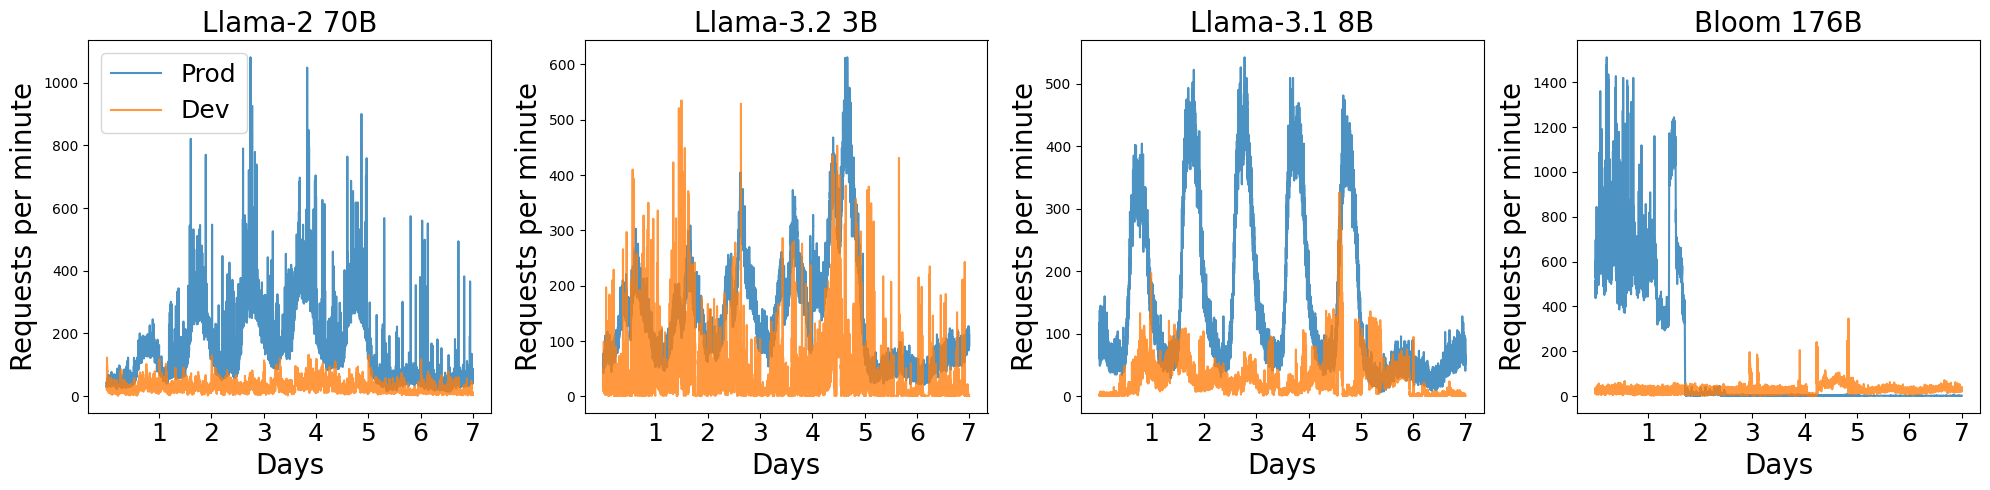

In [18]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

pl = ax[0]
df_A = df.loc[df["model_type"] == "A"]
df_temp = df_A.loc[df_A["workload_type"] == "prod"]
df_temp["arrival_timestamp_int"] = df_temp["arrival_timestamp_int"].apply(lambda x: 60 * (x//60))
df_temp = df_temp.groupby("arrival_timestamp_int").agg({"prompt_size": "count", "token_size": "count"}).reset_index()
pl.plot(df_temp["arrival_timestamp_int"], df_temp["prompt_size"], label="Prod", alpha=0.8)
df_temp = df_A.loc[df_A["workload_type"] == "dev"]
df_temp["arrival_timestamp_int"] = df_temp["arrival_timestamp_int"].apply(lambda x: 60 * (x//60))
df_temp = df_temp.groupby("arrival_timestamp_int").agg({"prompt_size": "count", "token_size": "count"}).reset_index()
pl.plot(df_temp["arrival_timestamp_int"], df_temp["prompt_size"], label="Dev", alpha=0.8)
pl.set_xticks(ticks=[i*one_day for i in range(1, 8)], labels=[f"{i}" for i in range(1, 8)], fontsize=18)
pl.set_xlabel("Days", fontsize=20)
pl.set_ylabel("Requests per minute", fontsize=20)
pl.set_title("Llama-2 70B", fontsize=20)
pl.legend(fontsize=18)
# plt.savefig("A_arrival.pdf", dpi=300, backend="pgf")
# plt.close(fig)
# plt.show()

# fig = plt.figure(figsize=(5, 5))
pl = ax[1]
df_A = df.loc[df["model_type"] == "B"]
df_temp = df_A.loc[df_A["workload_type"] == "prod"]
df_temp["arrival_timestamp_int"] = df_temp["arrival_timestamp_int"].apply(lambda x: 60 * (x//60))
df_temp = df_temp.groupby("arrival_timestamp_int").agg({"prompt_size": "count", "token_size": "count"}).reset_index()
pl.plot(df_temp["arrival_timestamp_int"], df_temp["prompt_size"], label="Prod", alpha=0.8)
df_temp = df_A.loc[df_A["workload_type"] == "dev"]
df_temp["arrival_timestamp_int"] = df_temp["arrival_timestamp_int"].apply(lambda x: 60 * (x//60))
df_temp = df_temp.groupby("arrival_timestamp_int").agg({"prompt_size": "count", "token_size": "count"}).reset_index()
pl.plot(df_temp["arrival_timestamp_int"], df_temp["prompt_size"], label="Dev", alpha=0.8)
pl.set_xticks(ticks=[i*one_day for i in range(1, 8)], labels=[f"{i}" for i in range(1, 8)], fontsize=18)
pl.set_xlabel("Days", fontsize=20)
pl.set_title("Llama-3.2 3B", fontsize=20)
pl.set_ylabel("Requests per minute", fontsize=20)
# plt.legend()
# plt.savefig("B_arrival.pdf", dpi=300, backend="pgf")
# plt.close(fig)

# fig = plt.figure(figsize=(5, 5))
pl = ax[2]
df_A = df.loc[df["model_type"] == "C"]
df_temp = df_A.loc[df_A["workload_type"] == "prod"]
df_temp["arrival_timestamp_int"] = df_temp["arrival_timestamp_int"].apply(lambda x: 60 * (x//60))
df_temp = df_temp.groupby("arrival_timestamp_int").agg({"prompt_size": "count", "token_size": "count"}).reset_index()
pl.plot(df_temp["arrival_timestamp_int"], df_temp["prompt_size"], label="Prod", alpha=0.8)
df_temp = df_A.loc[df_A["workload_type"] == "dev"]
df_temp["arrival_timestamp_int"] = df_temp["arrival_timestamp_int"].apply(lambda x: 60 * (x//60))
df_temp = df_temp.groupby("arrival_timestamp_int").agg({"prompt_size": "count", "token_size": "count"}).reset_index()
pl.plot(df_temp["arrival_timestamp_int"], df_temp["prompt_size"], label="Dev", alpha=0.8)
pl.set_xticks(ticks=[i*one_day for i in range(1, 8)], labels=[f"{i}" for i in range(1, 8)], fontsize=18)
pl.set_xlabel("Days", fontsize=20)
pl.set_ylabel("Requests per minute", fontsize=20)
pl.set_title("Llama-3.1 8B", fontsize=20)
# plt.legend()
# plt.savefig("C_arrival.pdf", dpi=300, backend="pgf")
# plt.close(fig)

# fig = plt.figure(figsize=(5, 5))
pl = ax[3]
df_A = df.loc[df["model_type"] == "D"]
df_temp = df_A.loc[df_A["workload_type"] == "prod"]
df_temp["arrival_timestamp_int"] = df_temp["arrival_timestamp_int"].apply(lambda x: 60 * (x//60))
df_temp = df_temp.groupby("arrival_timestamp_int").agg({"prompt_size": "count", "token_size": "count"}).reset_index()
pl.plot(df_temp["arrival_timestamp_int"], df_temp["prompt_size"], label="Prod", alpha=0.8)
df_temp = df_A.loc[df_A["workload_type"] == "dev"]
df_temp["arrival_timestamp_int"] = df_temp["arrival_timestamp_int"].apply(lambda x: 60 * (x//60))
df_temp = df_temp.groupby("arrival_timestamp_int").agg({"prompt_size": "count", "token_size": "count"}).reset_index()
pl.plot(df_temp["arrival_timestamp_int"], df_temp["prompt_size"], label="Dev", alpha=0.8)
pl.set_xticks(ticks=[i*one_day for i in range(1, 8)], labels=[f"{i}" for i in range(1, 8)], fontsize=18)
pl.set_xlabel("Days", fontsize=20)
pl.set_ylabel("Requests per minute", fontsize=20)
pl.set_title("Bloom 176B", fontsize=20)
# plt.legend()
fig.tight_layout()
plt.show()
# plt.savefig("all_arrival.pdf", dpi=300, backend="pgf")
plt.close(fig)


In [19]:
def generate_save_arima_predictions(df, filepath):
    df = df.groupby("arrival_timestamp_int").agg({"prompt_size": "sum", "token_size": "sum"}).reset_index()
    df["arrival_timestamp_int"] = df["arrival_timestamp_int"].apply(lambda x: 60 * (x//60))
    df = df.groupby("arrival_timestamp_int").agg({"prompt_size": "sum", "token_size": "sum"}).reset_index()
    model = ARIMA(df.prompt_size, order=(3,1,2))
    model_fit = model.fit()
    preds = model_fit.predict()
    df_preds = pd.DataFrame({"Predicted": preds, "Time": [i * 60 for i in range(len(preds))]})
    df_preds.to_csv(filepath)
    
    print(model_fit.summary())

    diffs = (preds - df["prompt_size"])
    print("Mean percentage error:", 100 * (np.mean(np.abs(diffs)) / np.mean(df["prompt_size"])))
    plt.plot(df["prompt_size"], label="Actual")
    plt.plot(preds, label="Predicted")
    plt.legend()
    plt.title(f"ARIME prediction for {filepath}")
    plt.show()

                               SARIMAX Results                                
Dep. Variable:            prompt_size   No. Observations:                10080
Model:                 ARIMA(3, 1, 2)   Log Likelihood             -137893.448
Date:                Wed, 15 Jan 2025   AIC                         275798.896
Time:                        08:59:59   BIC                         275842.206
Sample:                             0   HQIC                        275813.550
                              - 10080                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8233      0.303     -2.718      0.007      -1.417      -0.230
ar.L2          0.0878      0.031      2.811      0.005       0.027       0.149
ar.L3         -0.0030      0.010     -0.317      0.7

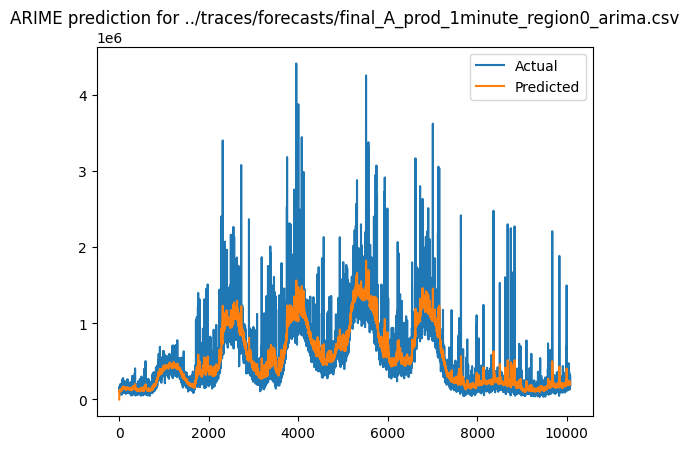

                               SARIMAX Results                                
Dep. Variable:            prompt_size   No. Observations:                10080
Model:                 ARIMA(3, 1, 2)   Log Likelihood             -127878.851
Date:                Wed, 15 Jan 2025   AIC                         255769.702
Time:                        09:00:09   BIC                         255813.011
Sample:                             0   HQIC                        255784.356
                              - 10080                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7338      0.052     13.992      0.000       0.631       0.837
ar.L2          0.0116      0.015      0.796      0.426      -0.017       0.040
ar.L3          0.0327      0.014      2.268      0.0

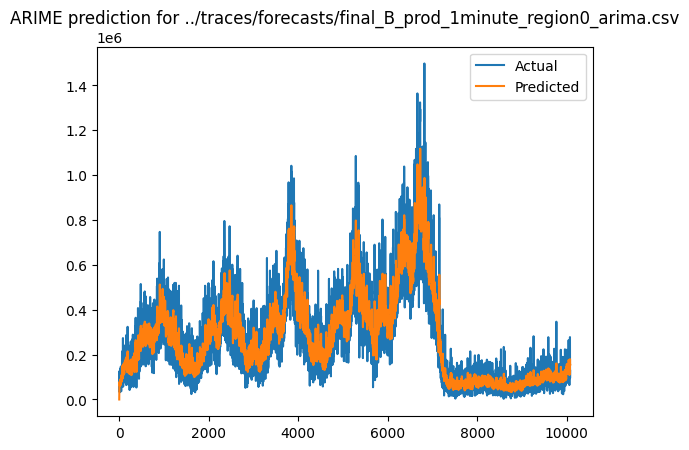

                               SARIMAX Results                                
Dep. Variable:            prompt_size   No. Observations:                10073
Model:                 ARIMA(3, 1, 2)   Log Likelihood             -127131.163
Date:                Wed, 15 Jan 2025   AIC                         254274.327
Time:                        09:00:15   BIC                         254317.632
Sample:                             0   HQIC                        254288.980
                              - 10073                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8462      0.064    -13.196      0.000      -0.972      -0.721
ar.L2          0.0820      0.012      6.775      0.000       0.058       0.106
ar.L3          0.0318      0.010      3.111      0.0

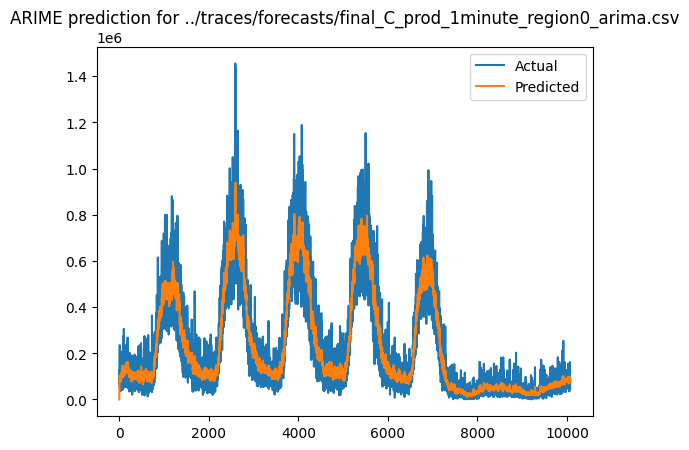

/anaconda/envs/capall/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/anaconda/envs/capall/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:            prompt_size   No. Observations:                 4636
Model:                 ARIMA(3, 1, 2)   Log Likelihood              -62695.375
Date:                Wed, 15 Jan 2025   AIC                         125402.750
Time:                        09:00:21   BIC                         125441.399
Sample:                             0   HQIC                        125416.348
                               - 4636                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5044      0.671     -0.752      0.452      -1.819       0.811
ar.L2          0.0479      0.080      0.600      0.549      -0.109       0.204
ar.L3         -0.0215      0.018     -1.200      0.2

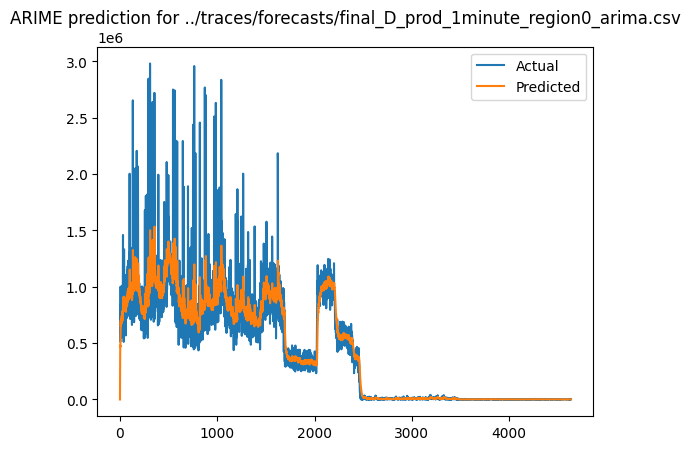

                               SARIMAX Results                                
Dep. Variable:            prompt_size   No. Observations:                10078
Model:                 ARIMA(3, 1, 2)   Log Likelihood             -131258.247
Date:                Wed, 15 Jan 2025   AIC                         262528.494
Time:                        09:00:28   BIC                         262571.802
Sample:                             0   HQIC                        262543.148
                              - 10078                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7808      0.141     -5.530      0.000      -1.058      -0.504
ar.L2          0.0702      0.016      4.380      0.000       0.039       0.102
ar.L3          0.0011      0.010      0.113      0.9

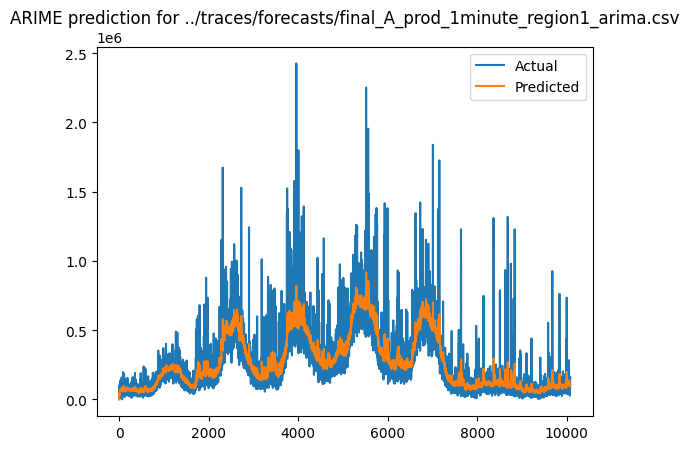

                               SARIMAX Results                                
Dep. Variable:            prompt_size   No. Observations:                10080
Model:                 ARIMA(3, 1, 2)   Log Likelihood             -128285.394
Date:                Wed, 15 Jan 2025   AIC                         256582.788
Time:                        09:00:37   BIC                         256626.098
Sample:                             0   HQIC                        256597.442
                              - 10080                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7696      0.025    -30.552      0.000      -0.819      -0.720
ar.L2          0.3674      0.012     30.230      0.000       0.344       0.391
ar.L3          0.1701      0.009     19.799      0.0

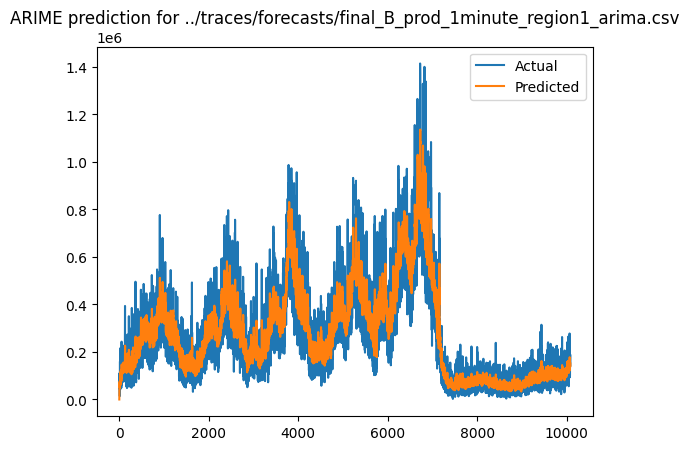

                               SARIMAX Results                                
Dep. Variable:            prompt_size   No. Observations:                10080
Model:                 ARIMA(3, 1, 2)   Log Likelihood             -131331.302
Date:                Wed, 15 Jan 2025   AIC                         262674.604
Time:                        09:00:44   BIC                         262717.914
Sample:                             0   HQIC                        262689.259
                              - 10080                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4190      0.566     -0.741      0.459      -1.528       0.690
ar.L2          0.0845      0.052      1.630      0.103      -0.017       0.186
ar.L3          0.0272      0.018      1.481      0.1

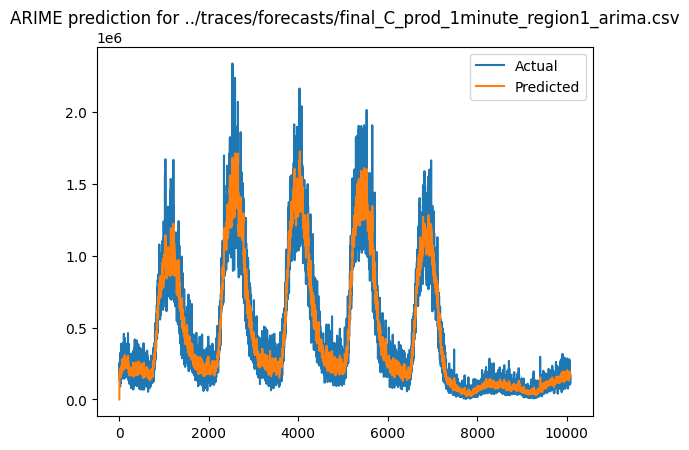

/anaconda/envs/capall/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/anaconda/envs/capall/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:            prompt_size   No. Observations:                 4666
Model:                 ARIMA(3, 1, 2)   Log Likelihood              -62974.884
Date:                Wed, 15 Jan 2025   AIC                         125961.768
Time:                        09:00:51   BIC                         126000.455
Sample:                             0   HQIC                        125975.374
                               - 4666                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7475      0.043    -17.508      0.000      -0.831      -0.664
ar.L2          0.0516      0.015      3.555      0.000       0.023       0.080
ar.L3         -0.0755      0.010     -7.504      0.0

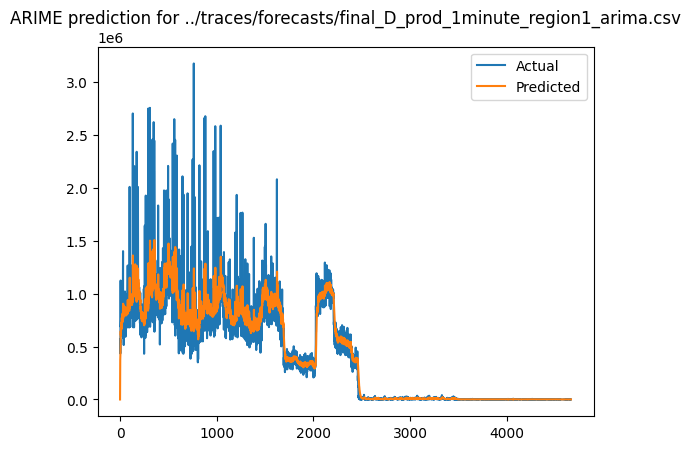

                               SARIMAX Results                                
Dep. Variable:            prompt_size   No. Observations:                10079
Model:                 ARIMA(3, 1, 2)   Log Likelihood             -131301.601
Date:                Wed, 15 Jan 2025   AIC                         262615.203
Time:                        09:01:00   BIC                         262658.511
Sample:                             0   HQIC                        262629.857
                              - 10079                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8570      0.102     -8.372      0.000      -1.058      -0.656
ar.L2          0.0994      0.014      6.918      0.000       0.071       0.128
ar.L3          0.0022      0.008      0.257      0.7

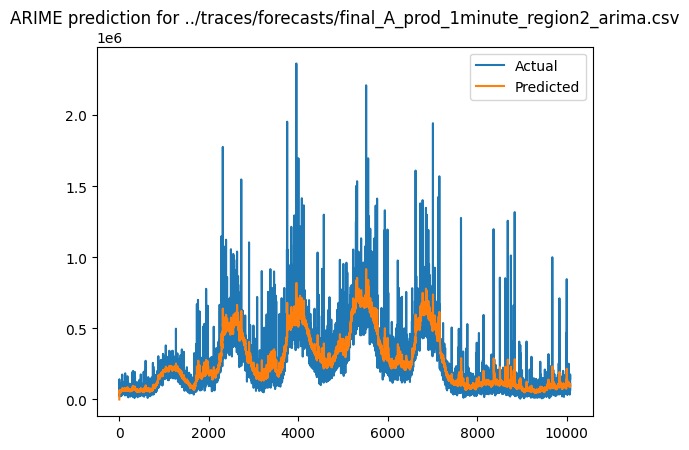

/anaconda/envs/capall/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/anaconda/envs/capall/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:            prompt_size   No. Observations:                10080
Model:                 ARIMA(3, 1, 2)   Log Likelihood             -132278.810
Date:                Wed, 15 Jan 2025   AIC                         264569.620
Time:                        09:01:12   BIC                         264612.929
Sample:                             0   HQIC                        264584.274
                              - 10080                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6050      0.050     12.088      0.000       0.507       0.703
ar.L2          0.0765      0.017      4.627      0.000       0.044       0.109
ar.L3          0.0799      0.015      5.318      0.0

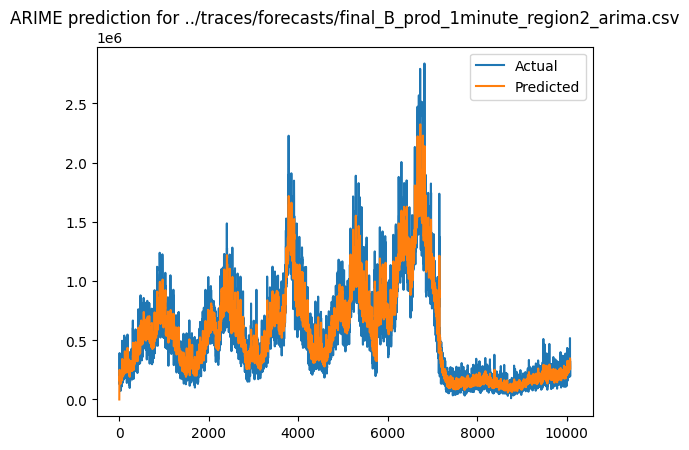

                               SARIMAX Results                                
Dep. Variable:            prompt_size   No. Observations:                10076
Model:                 ARIMA(3, 1, 2)   Log Likelihood             -127064.316
Date:                Wed, 15 Jan 2025   AIC                         254140.632
Time:                        09:01:19   BIC                         254183.939
Sample:                             0   HQIC                        254155.286
                              - 10076                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8549      0.100     -8.583      0.000      -1.050      -0.660
ar.L2          0.0456      0.013      3.645      0.000       0.021       0.070
ar.L3          0.0115      0.010      1.199      0.2

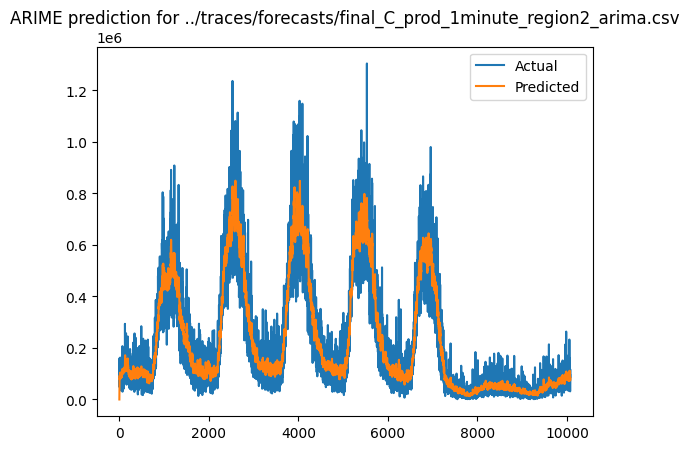

/anaconda/envs/capall/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/anaconda/envs/capall/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:            prompt_size   No. Observations:                 5532
Model:                 ARIMA(3, 1, 2)   Log Likelihood              -77932.473
Date:                Wed, 15 Jan 2025   AIC                         155876.945
Time:                        09:01:28   BIC                         155916.654
Sample:                             0   HQIC                        155890.792
                               - 5532                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7507      0.031    -23.998      0.000      -0.812      -0.689
ar.L2          0.0778      0.013      6.090      0.000       0.053       0.103
ar.L3         -0.0522      0.009     -5.831      0.0

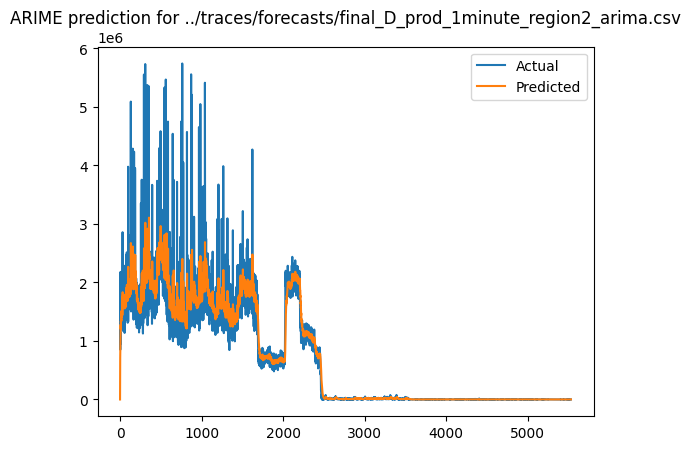

In [20]:
generate_save_arima_predictions(df.loc[(
    (df["model_type"] == "A") & \
    (df["workload_type"] == "prod") & \
    (df["regions"].apply(lambda x: x//100) == 0)
)], "../traces/forecasts/final_A_prod_1minute_region0_arima.csv")
generate_save_arima_predictions(df.loc[(
    (df["model_type"] == "B") & \
    (df["workload_type"] == "prod") & \
    (df["regions"].apply(lambda x: x//100) == 0)
)], "../traces/forecasts/final_B_prod_1minute_region0_arima.csv")
generate_save_arima_predictions(df.loc[(
    (df["model_type"] == "C") & \
    (df["workload_type"] == "prod") & \
    (df["regions"].apply(lambda x: x//100) == 0)
)], "../traces/forecasts/final_C_prod_1minute_region0_arima.csv")
generate_save_arima_predictions(df.loc[(
    (df["model_type"] == "D") & \
    (df["workload_type"] == "prod") & \
    (df["regions"].apply(lambda x: x//100) == 0)
)], "../traces/forecasts/final_D_prod_1minute_region0_arima.csv")

generate_save_arima_predictions(df.loc[(
    (df["model_type"] == "A") & \
    (df["workload_type"] == "prod") & \
    (df["regions"].apply(lambda x: x//100) == 1)
)], "../traces/forecasts/final_A_prod_1minute_region1_arima.csv")
generate_save_arima_predictions(df.loc[(
    (df["model_type"] == "B") & \
    (df["workload_type"] == "prod") & \
    (df["regions"].apply(lambda x: x//100) == 1)
)], "../traces/forecasts/final_B_prod_1minute_region1_arima.csv")
generate_save_arima_predictions(df.loc[(
    (df["model_type"] == "C") & \
    (df["workload_type"] == "prod") & \
    (df["regions"].apply(lambda x: x//100) == 1)
)], "../traces/forecasts/final_C_prod_1minute_region1_arima.csv")
generate_save_arima_predictions(df.loc[(
    (df["model_type"] == "D") & \
    (df["workload_type"] == "prod") & \
    (df["regions"].apply(lambda x: x//100) == 1)
)], "../traces/forecasts/final_D_prod_1minute_region1_arima.csv")

generate_save_arima_predictions(df.loc[(
    (df["model_type"] == "A") & \
    (df["workload_type"] == "prod") & \
    (df["regions"].apply(lambda x: x//100) == 2)
)], "../traces/forecasts/final_A_prod_1minute_region2_arima.csv")
generate_save_arima_predictions(df.loc[(
    (df["model_type"] == "B") & \
    (df["workload_type"] == "prod") & \
    (df["regions"].apply(lambda x: x//100) == 2)
)], "../traces/forecasts/final_B_prod_1minute_region2_arima.csv")
generate_save_arima_predictions(df.loc[(
    (df["model_type"] == "C") & \
    (df["workload_type"] == "prod") & \
    (df["regions"].apply(lambda x: x//100) == 2)
)], "../traces/forecasts/final_C_prod_1minute_region2_arima.csv")
generate_save_arima_predictions(df.loc[(
    (df["model_type"] == "D") & \
    (df["workload_type"] == "prod") & \
    (df["regions"].apply(lambda x: x//100) == 2)
)], "../traces/forecasts/final_D_prod_1minute_region2_arima.csv")


In [21]:
for model in ["A", "B", "C", "D"]:
    for region in [0, 1, 2]:
        df.loc[(
            (df["model_type"] == model) & \
            (df["workload_type"] == "dev") & \
            (df["regions"].apply(lambda x: x//100) == region)
)].to_csv(f"../traces/forecasts/final_{model}_dev_region{region}_exact.csv")